<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [46]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [47]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [48]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [49]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


Categorías de la variable Rating: 
[3 4 2 1 0]



Representación de cada categoría: 
4    55.386246
3    21.677488
2    12.468531
1     6.841571
0     3.626165
Name: Rating, dtype: float64





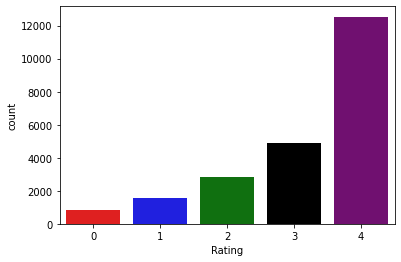

In [50]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
cat = df_reviews['Rating'].unique()
print(f'Categorías de la variable Rating: \n{cat}')
print('\n\n')

prop = df_reviews['Rating'].value_counts()/len(df_reviews) 
print(f'Representación de cada categoría: \n{prop*100}')

print('\n\n')
sns.countplot(x = df_reviews['Rating'], palette = ['red', 'blue', 'green', 'black', 'purple'])

In [51]:
# vamos a reducir la variable objetivo a 3 categorías
"""
def replace(rating):
  if rating < 2:
    return 0
  if rating > 2:
    return 2
  return 1

df_reviews["Rating"] =df_reviews["Rating"].apply(replace)
"""

'\ndef replace(rating):\n  if rating < 2:\n    return 0\n  if rating > 2:\n    return 2\n  return 1\n\ndf_reviews["Rating"] =df_reviews["Rating"].apply(replace)\n'

In [52]:
"""
cat = df_reviews['Rating'].unique()
print(f'Categorías de la variable Rating: \n{cat}')
print('\n\n')

prop = df_reviews['Rating'].value_counts()/len(df_reviews) 
print(f'Representación de cada categoría: \n{prop*100}')

print('\n\n')
sns.countplot(x = df_reviews['Rating'], palette = ['red', 'blue', 'green', 'black', 'purple'])
"""

"\ncat = df_reviews['Rating'].unique()\nprint(f'Categorías de la variable Rating: \n{cat}')\nprint('\n\n')\n\nprop = df_reviews['Rating'].value_counts()/len(df_reviews) \nprint(f'Representación de cada categoría: \n{prop*100}')\n\nprint('\n\n')\nsns.countplot(x = df_reviews['Rating'], palette = ['red', 'blue', 'green', 'black', 'purple'])\n"

In [53]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].to_numpy()
reviews

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [54]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
reviews_number = reviews.shape[0]
print(f'Hay {reviews_number} reviews en el dataset')

Hay 22641 reviews en el dataset


In [55]:
# Alumno: Concatenar todas las reviews para armar el corpus
oneline = np.add.reduce(reviews)
oneline

Output hidden; open in https://colab.research.google.com to view.

In [56]:
print(f'Hay {len(oneline)} palabras en el corpus, previo al procesamiento')

Hay 6989003 palabras en el corpus, previo al procesamiento


In [57]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(oneline)

In [58]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:10]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortablelove',
 'this',
 'dress',
 "it's"]

In [59]:
# Alumno: ¿Cuántos tokens/palabras hay?
print(f'Hay {len(tokens)} términos en el corpus')

Hay 1366924 términos en el corpus


In [60]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.

from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tokenizer = Tokenizer(num_words=num_words) 
tokenizer.fit_on_texts(tokens) 

In [61]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tokenizer.word_index
print(f'Tamaño del voabulario: {len(word_index)}')

Tamaño del voabulario: 17629


In [62]:
# Alumno: Convertir las palabras/tokens a números
sequences = tokenizer.texts_to_sequences(reviews)
sequences[0][:20]

[257, 535, 914, 3, 661, 3, 68]

In [63]:
# Alumno: Determinar cual es la oración más larga
maxlen = max(len(s) for s in sequences)
print(f'La oración más larga tiene {maxlen} palabras')

La oración más larga tiene 115 palabras


In [64]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(sequences, padding='pre', maxlen=200)

In [65]:
# Alumno: Observar las dimensiones de la variable input
print(f'La variable input tiene tamaño: {X.shape}')

La variable input tiene tamaño: (22641, 200)


In [67]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y_original = df_reviews['Rating'].values
y = to_categorical(y_original,  num_classes=5, dtype='float32')
print(y.shape)

(22641, 5)


In [68]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # tenemos 5 categorías
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 200 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

#### Entrenamiento con embeddings propios

In [70]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           100050    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 64)           29440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [71]:
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 116s 227ms/step - loss: 1.0074 - accuracy: 0.5947 - val_loss: 0.9370 - val_accuracy: 0.6094
Epoch 2/5
453/453 [==============================] - 102s 225ms/step - loss: 0.8698 - accuracy: 0.6277 - val_loss: 0.9163 - val_accuracy: 0.6180
Epoch 3/5
453/453 [==============================] - 103s 226ms/step - loss: 0.8174 - accuracy: 0.6544 - val_loss: 0.9125 - val_accuracy: 0.6130
Epoch 4/5
453/453 [==============================] - 102s 225ms/step - loss: 0.7653 - accuracy: 0.6713 - val_loss: 0.9315 - val_accuracy: 0.6227
Epoch 5/5
453/453 [==============================] - 102s 225ms/step - loss: 0.7272 - accuracy: 0.6915 - val_loss: 0.9452 - val_accuracy: 0.6105


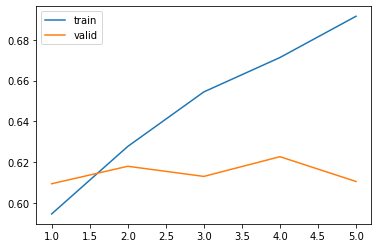

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [73]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 6s 45ms/step - loss: 0.8958 - accuracy: 0.6282


[0.8958096504211426, 0.6281740069389343]